In [80]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Constants
num_bank_nodes = 50
num_server_nodes = int(0.15 * num_bank_nodes)
x_min, x_max = 0, 1000
y_min, y_max = 0, 1000
cover_range = 1000
alpha = 1.0
beta = 0.1

# Generate nodes
def generate_nodes(num_nodes, x_min, x_max, y_min, y_max):
    return np.random.uniform(low=[x_min, y_min], high=[x_max, y_max], size=(num_nodes, 2))

bank_nodes = generate_nodes(num_bank_nodes, x_min, x_max, y_min, y_max)
server_nodes = generate_nodes(num_server_nodes, x_min, x_max, y_min, y_max)

# Calculate distance
def calDistance(pos1, pos2):
    return np.linalg.norm(pos1 - pos2)

connections = {}
for i in range(num_bank_nodes):
    connections[i] = {'task_id': i, 'fns': []}
    for j in range(num_server_nodes):
        if calDistance(bank_nodes[i], server_nodes[j]) <= cover_range:
            connections[i]['fns'].append(j)

# Fitness function
def fitness_func(population):
    distance = 0
    count = np.zeros(num_server_nodes)
    for task_idx, fn_idx in enumerate(population):
        if fn_idx != -1:
            distance += calDistance(bank_nodes[int(task_idx)], server_nodes[int(fn_idx)])
            count[int(fn_idx)] += 1
    load_cost = np.sum(count**2)
    return alpha * distance + beta * load_cost

In [81]:
def generate_initial_population(num_individuals, tasks, task_options_by_task):
    """Generate an initial population for the optimization algorithm."""
    initial_population = []
    for _ in range(num_individuals):
        individual = []
        for task_options in task_options_by_task:
            if task_options:
                fn_idx = random.randint(0, len(task_options) - 1)
                individual.append(fn_idx)
            else:
                individual.append(-1)
        initial_population.append(individual)
    return initial_population

task_options_by_task = [connections[j]['fns'] if connections[j]['fns'] else [-1] for j in range(num_bank_nodes)]
common_initial_population = generate_initial_population(20, num_bank_nodes, task_options_by_task)

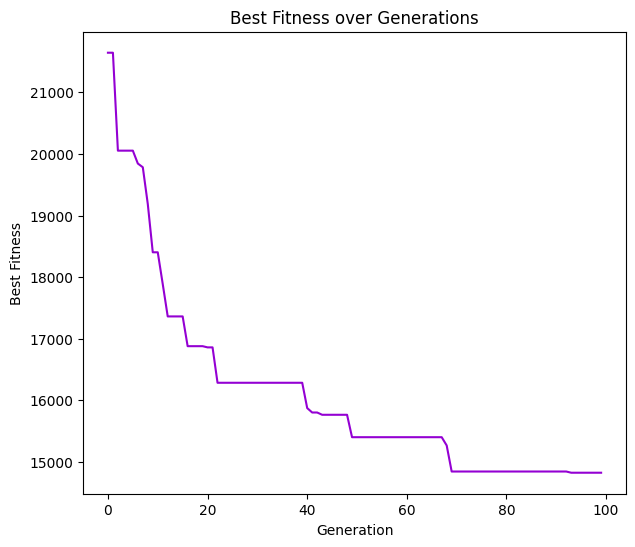

In [82]:
class GeneticAlgorithm:
    def __init__(self, pop_size, tasks, max_iter):
        self.cost_func = None
        self.pop_size = pop_size
        self.tasks = tasks
        self.max_iter = max_iter
        self.mutation_rate = 0.1
        self.population = common_initial_population.copy()
        self.best_individual = None
        self.best_fitness = float('inf')
        self.avg_fitness = []
        self.best_fitnesses = []

    def evaluate_population(self):
        fitness_values = np.zeros(len(self.population))
        for i in range(len(self.population)):
            fitness_values[i] = self.cost_func(self.population[i])
        return fitness_values

    def tournament_selection(self, fitness_values, k=2):
        selected_indices = np.random.choice(self.pop_size, k, replace=False)
        best_index = selected_indices[np.argmin(fitness_values[selected_indices])]
        return self.population[best_index]

    def crossover(self, parent1, parent2):
        crossover_point = np.random.randint(1, self.tasks)
        return np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))

    def mutate(self, individual):  # Exploitation by [-1, +1]
        for i in range(self.tasks):
            if len(connections[i]['fns'])>0 and np.random.rand() < self.mutation_rate:
                if individual[i] <= 0 :
                    individual[i] += 1;
                elif individual[i]>= len(connections[i]['fns']) - 1:
                    individual[i] += -1
                else :
                    individual[i] += np.random.choice([-1, 1])
        return individual

    def evolve(self):
        fitness_values = self.evaluate_population()
        best_idx = np.argmin(fitness_values)
        best_fitness = fitness_values[best_idx]
        if best_fitness < self.best_fitness:
            self.best_fitness = best_fitness
            self.best_individual = self.population[best_idx]
        self.best_fitnesses.append(self.best_fitness)

        new_population = []
        while len(new_population) < self.pop_size:
            parent1 = self.tournament_selection(fitness_values)
            parent2 = self.tournament_selection(fitness_values)
            child = self.crossover(parent1, parent2)
            child = self.mutate(child)
            new_population.append(child)

        # Evaluate and sort new population by fitness for survivor selection
        indexed_fitness = [(ind, self.cost_func(ind)) for ind in new_population]
        indexed_fitness.sort(key=lambda x: x[1])
        self.population = [x[0] for x in indexed_fitness[:self.pop_size]]

    def start(self):
        for _ in range(self.max_iter):
            self.evolve()
        plt.figure(figsize=(7, 6))
        plt.plot(self.best_fitnesses, color='darkviolet')
        plt.title('Best Fitness over Generations')
        plt.xlabel('Generation')
        plt.ylabel('Best Fitness')
        plt.show()

ga = GeneticAlgorithm(pop_size = 20, tasks = num_bank_nodes, max_iter = 100)
ga.cost_func = fitness_func
ga.start()

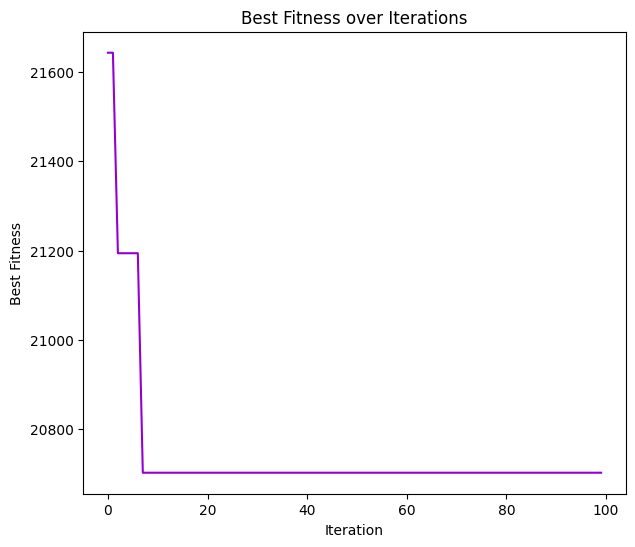

In [83]:
class JayaAlgorithm:
    def __init__(self, pop_size, tasks, max_iter):
        self.cost_func = None
        self.pop_size = pop_size
        self.tasks = tasks
        self.max_iter = max_iter
        self.population = common_initial_population.copy()
        self.best_individual = None
        self.best_fitnesses = []

    def find_best_and_worst(self):
        fitness_values = np.array([self.cost_func(individual) for individual in self.population])
        best_idx = np.argmin(fitness_values)
        worst_idx = np.argmax(fitness_values)
        return best_idx, worst_idx

    def evolve(self):
        for _ in range(self.max_iter):
            best_idx, worst_idx = self.find_best_and_worst()
            best_solution = self.population[best_idx]
            worst_solution = self.population[worst_idx]
            
            for i in range(self.pop_size):
                if i != best_idx and i != worst_idx:
                    new_solution = self.population[i].copy()
                    for j in range(self.tasks):
                        r1, r2 = np.random.random(), np.random.random()
                        # Move towards best, away from worst
                        new_solution[j] = new_solution[j] + \
                                          r1 * (best_solution[j] - abs(new_solution[j])) - \
                                          r2 * (worst_solution[j] - abs(new_solution[j]))
                        # Ensure new solution does not go out of bounds (if applicable)
                        if connections[j]['fns']:
                            new_solution[j] = np.clip(new_solution[j], 0, len(connections[j]['fns']) - 1)
                    
                    # Update if the new solution is better
                    if self.cost_func(new_solution) < self.cost_func(self.population[i]):
                        self.population[i] = new_solution

            # Update the best fitness found so far
            self.best_individual = best_solution
            self.best_fitnesses.append(self.cost_func(best_solution))

    def start(self):
        self.evolve()
        plt.figure(figsize=(7, 6))
        plt.plot(self.best_fitnesses, color='darkviolet')
        plt.title('Best Fitness over Iterations')
        plt.xlabel('Iteration')
        plt.ylabel('Best Fitness')
        plt.show()

jaya = JayaAlgorithm(pop_size=20, tasks=num_bank_nodes, max_iter=100)
jaya.cost_func = fitness_func
jaya.start()

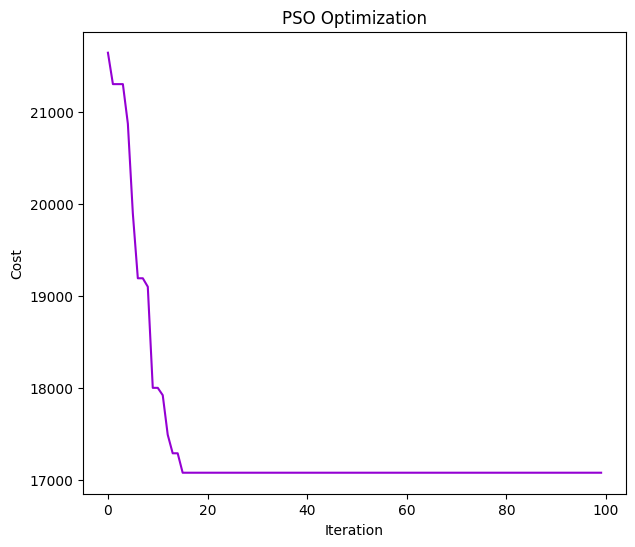

In [84]:
class PSO:
    def __init__(self, pop_size, tasks, max_iter):
        self.cost_func = None
        self.w = 0.8  # Inertia weight
        self.c1 = 0.5  # Cognitive weight
        self.c2 = 2.5  # Social weight
        self.max_iter = max_iter
        self.pop_size = pop_size
        self.tasks = tasks
        
        self.positions = []
        self.velocities = []
        self.personal_best = []
        self.global_best = None
        self.global_best_cost = float('inf')
        
        self.costs = []
    def generate_initial_pop(self):
        for i in range(self.pop_size):
            position = common_initial_population[i].copy()
            self.positions.append(position)
            self.personal_best.append(position)
            if self.global_best_cost == None or self.evaluate(position)<self.global_best_cost :
                    self.global_best = position
                    self.global_best_cost = self.evaluate(position)
            self.velocities.append(random.randint(-len(connections[j]['fns'])+1, len(connections[j]['fns'])-1))
    
    def evaluate(self, position):
        return self.cost_func(position)  

    def update_velocity(self, _iter):
        if _iter < self.max_iter/3:
            self.w = 0.5
        elif _iter < 2* self.max_iter/3 :
            self.w = 0.3
        else :
            self.w = 0.1
        for i in range(self.pop_size):
            r1, r2 = np.random.random(), np.random.random()
            cognitive = self.c1 * r1 * (np.array(self.personal_best[i]) - np.array(self.positions[i]))
            social = self.c2 * r2 * (np.array(self.global_best) - np.array(self.positions[i]))
            self.velocities[i] = self.w * np.array(self.velocities[i]) + cognitive + social

    def update_position(self):
        for i in range(self.pop_size):
            self.positions[i] = np.array(self.positions[i]) + np.array(self.velocities[i])
            self.positions[i] = np.clip(self.positions[i], 0, len(connections[0]['fns']) - 1).astype(int)

    def update_personal_best_and_gbest(self):
        for i in range(self.pop_size):
            cost = self.evaluate(self.positions[i])
            if cost < self.evaluate(self.personal_best[i]):
                self.personal_best[i] = self.positions[i].copy()
                if cost < self.global_best_cost:
                    self.global_best = self.positions[i].copy()
                    self.global_best_cost = cost

    def start(self):
        self.generate_initial_pop()
        for _iter in range(self.max_iter):
            self.costs.append(self.global_best_cost)
            self.update_velocity(_iter)
            self.update_position()
            self.update_personal_best_and_gbest()
        
        plt.figure(figsize=(7, 6))
        plt.plot(self.costs, color='darkviolet')
        plt.xlabel('Iteration')
        plt.ylabel('Cost')
        plt.title('PSO Optimization')
        plt.show()

pso = PSO(pop_size=20, tasks=num_bank_nodes, max_iter=100)
pso.cost_func = fitness_func
pso.start()

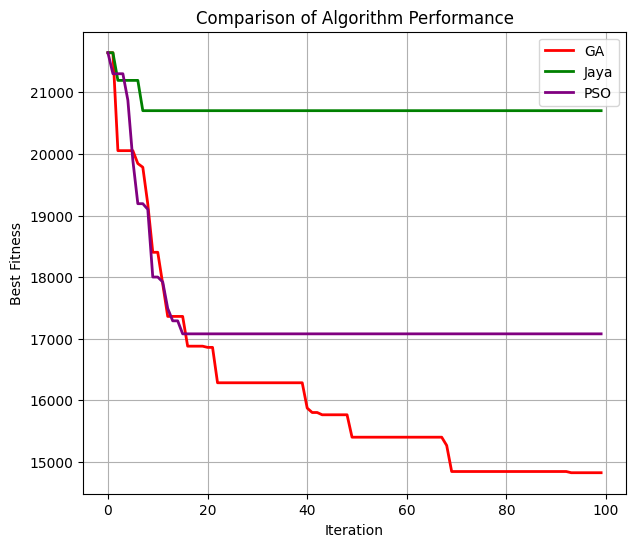

In [85]:
all_fitness_ga = ga.best_fitnesses
all_fitness_jaya = jaya.best_fitnesses
all_fitness_pso = pso.costs

# Combined plotting
plt.figure(figsize=(7, 6))  # Adjusted size for better readability
plt.plot(all_fitness_ga, label='GA', color='red',  linewidth=2)
plt.plot(all_fitness_jaya, label='Jaya', color='green', linewidth=2)
plt.plot(all_fitness_pso, label='PSO', color='purple', linewidth=2)
plt.title('Comparison of Algorithm Performance')
plt.xlabel('Iteration')
plt.ylabel('Best Fitness')
plt.legend()
plt.grid(True)
plt.show()

In [88]:
def plot_solution(bank_nodes, server_nodes, assignments):
    plt.figure(figsize=(7, 6))  # Adjusted size for better readability
    ax = plt.gca()

    # Plot bank nodes
    ax.scatter(bank_nodes[:, 0], bank_nodes[:, 1], c='blue', label='Bank Nodes')

    # Plot server nodes
    ax.scatter(server_nodes[:, 0], server_nodes[:, 1], c='red', label='Server Nodes')

    # Draw lines between assigned bank and server nodes
    for i in range(len(assignments)):
        if assignments[i] != -1:  # Ensure there is a valid server assigned
            bank = bank_nodes[i]
            server = server_nodes[assignments[i]]
            ax.plot([bank[0], server[0]], [bank[1], server[1]], 'gray', linestyle='--', alpha=0.5)

    plt.title('Optimal Assignment of Banks to Servers')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.show()


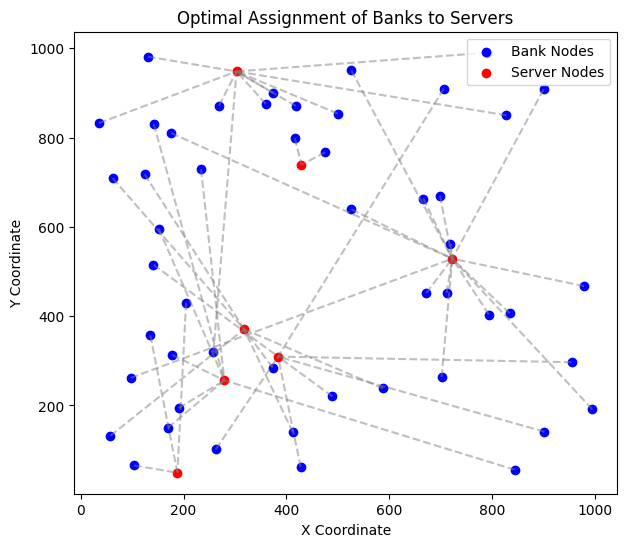

In [89]:
plot_solution(bank_nodes, server_nodes, ga.best_individual)